# NBA MVP Prediction Model: More Train Data - UofWaterloo ML Group 6

#### <div class="alert alert-block alert-success">Objective: Predict the NBA MVP of the most recent year in the data, which is season 2022, by predicting the Award Share score. The highest award share score is the MVP winner. You can think of the award share scoring as the total of how many first place (10 points), second place (7 points), third place (5 points), fourth place (3 points) and fifth place (1 point) votes each player recieves.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
# Import Libs
import numpy as np
import pandas as pd
import seaborn as sns
import time
from time import *
from time import time
np.random.seed(42)

# ML Model Imports
from sklearn.linear_model import LinearRegression, Ridge,Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Tools Import
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve

# Metrics Import
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score, mean_squared_error

Backing off send_request(...) for 0.4s (requests.exceptions.SSLError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)'))))
Backing off send_request(...) for 0.9s (requests.exceptions.SSLError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)'))))


In [3]:
# Show all Columns

pd.set_option('max_columns', None)

In [4]:
# Plot format standardization

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 7
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [5]:
import warnings
warnings.filterwarnings("ignore")

### Data Loading & Cleaning <a name='dataload'></a>

In [6]:
# Import data into dataframe
df = pd.read_csv('NBA_Dataset.csv')
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,fg3a_per_g,fg3_pct,fg2_per_g,fg2a_per_g,fg2_pct,efg_pct,ft_per_g,fta_per_g,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,0.580,0.579,4.1,5.8,0.706,2.3,6.4,8.7,3.0,0.8,2.7,3.0,2.9,23.9,2677,23.4,0.608,0.002,0.340,7.3,19.1,13.4,11.9,1.1,4.1,13.3,25.6,6.9,3.9,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,0.494,0.494,2.3,2.9,0.781,1.7,5.7,7.4,4.5,1.4,1.0,2.5,3.4,15.1,2393,18.6,0.529,0.001,0.227,6.6,20.2,13.6,22.1,2.3,1.9,14.8,22.8,2.5,4.7,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,0.475,0.480,3.3,4.8,0.680,1.7,3.1,4.9,3.2,0.7,0.4,2.6,3.0,18.7,1468,17.3,0.514,0.087,0.301,6.7,12.9,9.7,18.6,1.2,0.9,12.7,29.8,1.0,0.8,1.9,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,0.363,0.369,1.1,1.2,0.862,0.5,0.6,1.1,1.6,0.7,0.1,1.0,1.6,4.1,564,10.1,0.439,0.077,0.294,5.0,5.9,5.5,19.7,3.1,0.3,17.5,21.5,-0.3,0.8,0.5,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,0.475,0.477,3.5,4.6,0.747,0.4,1.3,1.7,8.0,0.8,0.0,2.6,1.9,12.6,2167,14.3,0.542,0.025,0.485,1.3,4.5,2.9,31.9,1.1,0.1,18.4,17.9,3.4,1.8,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17692,2022,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,0.518,0.3,0.9,0.354,2.4,4.3,0.554,0.550,0.4,0.9,0.469,1.5,2.5,4.0,2.0,1.0,0.3,1.0,1.6,6.2,845,17.0,0.548,0.176,0.180,9.8,16.8,13.1,17.7,3.1,2.0,15.0,17.4,0.9,1.3,2.2,0.126,0.1,2.1,2.2,0.9,0.000,0.00,0.00,0.500
17693,2022,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,0.382,6.3,12.3,0.512,0.536,6.6,7.3,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,2652,25.4,0.603,0.395,0.358,2.1,9.6,5.9,46.7,1.3,0.2,14.5,34.4,9.0,1.0,10.0,0.181,7.1,-2.0,5.2,4.8,0.000,1.56,1.55,0.524
17694,2022,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.526,0.0,0.2,0.091,2.3,4.2,0.547,0.528,0.7,1.1,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3,706,17.4,0.546,0.045,0.247,13.9,33.0,23.6,11.0,1.2,3.0,13.0,19.9,0.8,1.4,2.1,0.145,-1.4,0.4,-1.0,0.2,0.000,4.45,4.23,0.646
17695,2022,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.567,0.0,0.1,0.000,1.9,3.2,0.593,0.567,1.4,1.8,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2,355,17.2,0.627,0.044,0.544,14.9,24.1,19.3,9.4,1.1,1.7,14.6,15.9,0.9,0.2,1.1,0.143,-1.2,-1.0,-2.1,0.0,0.000,-8.88,-8.55,0.329


In [7]:
# Drop rows with NULL values

df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14783 entries, 0 to 17695
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            14783 non-null  int64  
 1   player            14783 non-null  object 
 2   pos               14783 non-null  object 
 3   age               14783 non-null  int64  
 4   team_id           14783 non-null  object 
 5   g                 14783 non-null  int64  
 6   gs                14783 non-null  int64  
 7   mp_per_g          14783 non-null  float64
 8   fg_per_g          14783 non-null  float64
 9   fga_per_g         14783 non-null  float64
 10  fg_pct            14783 non-null  float64
 11  fg3_per_g         14783 non-null  float64
 12  fg3a_per_g        14783 non-null  float64
 13  fg3_pct           14783 non-null  float64
 14  fg2_per_g         14783 non-null  float64
 15  fg2a_per_g        14783 non-null  float64
 16  fg2_pct           14783 non-null  float6

Data Column Legend

https://www.basketball-reference.com/about/glossary.html

In [9]:
# This adds a column telling us who the MVP was with a binary value

mvps = df.groupby(by = 'season').max('award_share')
mvps['was_mvp'] = '1'
df = df.merge(mvps[['award_share', 'was_mvp']], on = ['season', 'award_share'], how = 'left')
df['was_mvp'] = df['was_mvp'].fillna(value = 0)

df['was_mvp'] = df['was_mvp'].astype(int)

In [10]:
# This adds a column telling us who the MVP was with a boolan value

mvps = df.groupby(by = 'season').max('award_share')
mvps['was_mvp_TF'] = True
df = df.merge(mvps[['award_share', 'was_mvp_TF']], on = ['season', 'award_share'], how = 'left')
df['was_mvp_TF'] = df['was_mvp_TF'].fillna(value = False)

In [11]:
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,fg3a_per_g,fg3_pct,fg2_per_g,fg2a_per_g,fg2_pct,efg_pct,ft_per_g,fta_per_g,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,was_mvp,was_mvp_TF
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,0.580,0.579,4.1,5.8,0.706,2.3,6.4,8.7,3.0,0.8,2.7,3.0,2.9,23.9,2677,23.4,0.608,0.002,0.340,7.3,19.1,13.4,11.9,1.1,4.1,13.3,25.6,6.9,3.9,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,0,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,0.494,0.494,2.3,2.9,0.781,1.7,5.7,7.4,4.5,1.4,1.0,2.5,3.4,15.1,2393,18.6,0.529,0.001,0.227,6.6,20.2,13.6,22.1,2.3,1.9,14.8,22.8,2.5,4.7,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,0,False
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,0.475,0.480,3.3,4.8,0.680,1.7,3.1,4.9,3.2,0.7,0.4,2.6,3.0,18.7,1468,17.3,0.514,0.087,0.301,6.7,12.9,9.7,18.6,1.2,0.9,12.7,29.8,1.0,0.8,1.9,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341,0,False
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,0.363,0.369,1.1,1.2,0.862,0.5,0.6,1.1,1.6,0.7,0.1,1.0,1.6,4.1,564,10.1,0.439,0.077,0.294,5.0,5.9,5.5,19.7,3.1,0.3,17.5,21.5,-0.3,0.8,0.5,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768,0,False
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,0.475,0.477,3.5,4.6,0.747,0.4,1.3,1.7,8.0,0.8,0.0,2.6,1.9,12.6,2167,14.3,0.542,0.025,0.485,1.3,4.5,2.9,31.9,1.1,0.1,18.4,17.9,3.4,1.8,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14778,2022,Gabe York,SG,28,IND,2,0,10.5,1.0,3.5,0.286,0.5,3.0,0.167,0.5,0.5,1.000,0.357,1.5,2.5,0.600,0.0,1.0,1.0,2.0,1.0,0.5,0.5,2.0,4.0,21,12.7,0.435,0.857,0.714,0.0,10.8,5.3,25.1,4.7,4.1,9.8,20.8,0.0,0.0,0.0,0.059,-3.7,2.2,-1.5,0.0,0.000,-3.48,-3.26,0.305,0,False
14779,2022,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,0.518,0.3,0.9,0.354,2.4,4.3,0.554,0.550,0.4,0.9,0.469,1.5,2.5,4.0,2.0,1.0,0.3,1.0,1.6,6.2,845,17.0,0.548,0.176,0.180,9.8,16.8,13.1,17.7,3.1,2.0,15.0,17.4,0.9,1.3,2.2,0.126,0.1,2.1,2.2,0.9,0.000,0.00,0.00,0.500,0,False
14780,2022,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,0.382,6.3,12.3,0.512,0.536,6.6,7.3,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,2652,25.4,0.603,0.395,0.358,2.1,9.6,5.9,46.7,1.3,0.2,14.5,34.4,9.0,1.0,10.0,0.181,7.1,-2.0,5.2,4.8,0.000,1.56,1.55,0.524,0,False
14781,2022,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.526,0.0,0.2,0.091,2.3,4.2,0.547,0.528,0.7,1.1,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3,706,17.4,0.546,0.045,0.247,13.9,33.0,23.6,11.0,1.2,3.0,13.0,19.9,0.8,1.4,2.1,0.145,-1.4,0.4,-1.0,0.2,0.000,4.45,4.23,0.646,0,False


In [12]:
# Add MVP Ranking by Season

df['was_mpv_rank'] = df.groupby('season')['award_share'].rank(method='max',ascending=False)
df['was_mpv_rank'] = df['was_mpv_rank'].astype(int)
df = df.sort_values(['season','was_mpv_rank'], ascending=True).reset_index(drop=True)
df

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,fg3a_per_g,fg3_pct,fg2_per_g,fg2a_per_g,fg2_pct,efg_pct,ft_per_g,fta_per_g,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,was_mvp,was_mvp_TF,was_mpv_rank
0,1982,Moses Malone,C,26,HOU,81,81,42.0,11.7,22.5,0.519,0.0,0.1,0.000,11.7,22.4,0.520,0.519,7.8,10.2,0.762,6.9,7.8,14.7,1.8,0.9,1.5,3.6,2.6,31.1,3398,26.8,0.576,0.003,0.454,17.5,21.2,19.3,6.9,1.1,2.1,11.9,29.9,11.7,3.7,15.4,0.218,6.2,-1.8,4.5,5.5,0.735,-0.04,-0.39,0.561,1,True,1
1,1982,Larry Bird,PF,25,BOS,77,58,38.0,9.2,18.4,0.503,0.1,0.7,0.212,9.1,17.7,0.514,0.507,4.3,4.9,0.863,2.6,8.3,10.9,5.8,1.9,0.9,3.3,3.2,22.9,2923,22.6,0.557,0.037,0.269,7.7,23.4,15.8,22.5,2.3,1.2,13.8,25.2,6.8,5.7,12.5,0.205,4.4,2.3,6.6,6.4,0.588,6.38,6.35,0.768,0,False,2
2,1982,Julius Erving,SF,31,PHI,81,81,34.4,9.6,17.6,0.546,0.0,0.1,0.273,9.6,17.5,0.548,0.547,5.1,6.7,0.763,2.7,4.2,6.9,3.9,2.0,1.7,2.6,2.8,24.4,2789,25.9,0.593,0.008,0.377,9.3,13.0,11.2,18.1,2.8,2.9,11.4,28.1,8.7,4.6,13.3,0.229,6.0,1.7,7.7,6.8,0.294,5.73,5.74,0.707,0,False,3
3,1982,Gus Williams,PG,28,SEA,80,80,36.0,9.7,19.9,0.486,0.1,0.5,0.225,9.6,19.4,0.492,0.488,4.0,5.5,0.734,1.2,1.9,3.1,6.9,2.2,0.5,2.5,2.0,23.4,2876,21.8,0.526,0.025,0.274,3.6,5.5,4.6,31.0,2.9,0.7,9.9,28.5,5.9,4.3,10.2,0.171,4.1,1.0,5.1,5.2,0.167,4.13,3.69,0.634,0,False,4
4,1982,George Gervin,SG,29,SAS,79,79,35.7,12.6,25.2,0.500,0.1,0.5,0.278,12.4,24.7,0.504,0.502,7.0,8.1,0.864,1.7,3.2,5.0,2.4,1.0,0.6,2.7,2.7,32.3,2817,24.2,0.562,0.018,0.323,5.2,9.7,7.5,11.4,1.3,0.9,8.5,35.0,8.7,2.0,10.7,0.182,5.4,-1.5,3.9,4.2,0.159,2.30,1.79,0.585,0,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14778,2022,Gabe York,SG,28,IND,2,0,10.5,1.0,3.5,0.286,0.5,3.0,0.167,0.5,0.5,1.000,0.357,1.5,2.5,0.600,0.0,1.0,1.0,2.0,1.0,0.5,0.5,2.0,4.0,21,12.7,0.435,0.857,0.714,0.0,10.8,5.3,25.1,4.7,4.1,9.8,20.8,0.0,0.0,0.0,0.059,-3.7,2.2,-1.5,0.0,0.000,-3.48,-3.26,0.305,0,False,520
14779,2022,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,0.518,0.3,0.9,0.354,2.4,4.3,0.554,0.550,0.4,0.9,0.469,1.5,2.5,4.0,2.0,1.0,0.3,1.0,1.6,6.2,845,17.0,0.548,0.176,0.180,9.8,16.8,13.1,17.7,3.1,2.0,15.0,17.4,0.9,1.3,2.2,0.126,0.1,2.1,2.2,0.9,0.000,0.00,0.00,0.500,0,False,520
14780,2022,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,0.382,6.3,12.3,0.512,0.536,6.6,7.3,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,2652,25.4,0.603,0.395,0.358,2.1,9.6,5.9,46.7,1.3,0.2,14.5,34.4,9.0,1.0,10.0,0.181,7.1,-2.0,5.2,4.8,0.000,1.56,1.55,0.524,0,False,520
14781,2022,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.526,0.0,0.2,0.091,2.3,4.2,0.547,0.528,0.7,1.1,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3,706,17.4,0.546,0.045,0.247,13.9,33.0,23.6,11.0,1.2,3.0,13.0,19.9,0.8,1.4,2.1,0.145,-1.4,0.4,-1.0,0.2,0.000,4.45,4.23,0.646,0,False,520


In [13]:
df = df[df['season'] > 1981] 

#### Final Dataframes for Model Input <a name='dataframes'></a>

In [14]:
# Define Test and Validation Seasons
# Train data set 1982 to 2020
# Test data set 2021
# prediction season set 2022

test_season_1stmodel_selection = 2020
test_season = 2021
validation_season = 2022

In [15]:
# Define Training & Test dataframes

df_train = df[(df.season < test_season)]
df_train_1stmodel_selection = df[(df.season < test_season_1stmodel_selection)]
df_test_1stmodel_selection = df[(df.season >= test_season_1stmodel_selection)]
df_test = df[(df.season == test_season)]
df_val = df[(df.season == validation_season)]

In [16]:
# Split data into Target & Features

# Train data sets
y_train = df_train['award_share']
#X_train = df_train[['ws', 'gs','pts_per_g', 'fga_per_g', 'fg2a_per_g', 'ast_per_g', 'dws','drb_per_g', 'tov_per_g' ,'mp', 'mp_per_g', 'stl_per_g',
# 'ast_pct', 'blk_per_g', 'win_loss_pct', 'usg_pct', 'orb_per_g']]
X_train = df_train[['ws',
 'vorp',
 'ft_per_g',
 #'fta_per_g',
 #'gs',
 'pts_per_g',
 'fg_per_g',
 'fg2a_per_g',
 'ast_per_g',
 'dws',
 'drb_per_g',
 'tov_per_g',
 'mp',
 #'stl_per_g',
 'ast_pct']]

# Test data sets for passing through many models to select top 3 performing models. Season 2017 to 2022 which represents about 20% of the records.
y_train_1stmodel_selection = df_train_1stmodel_selection['award_share']
#X_train_1stmodel_selection = df_train_1stmodel_selection[['ws', 'gs', 'pts_per_g', 'fga_per_g', 'fg2a_per_g', 'ast_per_g', 'dws','drb_per_g', 'tov_per_g' ,'mp', 'mp_per_g', 'stl_per_g',
# 'ast_pct', 'blk_per_g', 'win_loss_pct', 'usg_pct', 'orb_per_g']]
X_train_1stmodel_selection = df_train_1stmodel_selection[['ws',
 'vorp',
 'ft_per_g',
 #'fta_per_g',
 #'gs',
 'pts_per_g',
 'fg_per_g',
 'fg2a_per_g',
 'ast_per_g',
 'dws',
 'drb_per_g',
 'tov_per_g',
 'mp',
 #'stl_per_g',
 'ast_pct']]

y_test_1stmodel_selection = df_test_1stmodel_selection['award_share']
#X_test_1stmodel_selection = df_test_1stmodel_selection[['ws', 'gs', 'pts_per_g', 'fga_per_g', 'fg2a_per_g', 'ast_per_g', 'dws','drb_per_g', 'tov_per_g' ,'mp', 'mp_per_g', 'stl_per_g',
# 'ast_pct', 'blk_per_g', 'win_loss_pct', 'usg_pct', 'orb_per_g']]
X_test_1stmodel_selection = df_test_1stmodel_selection[['ws',
 'vorp',
 'ft_per_g',
 #'fta_per_g',
 #'gs',
 'pts_per_g',
 'fg_per_g',
 'fg2a_per_g',
 'ast_per_g',
 'dws',
 'drb_per_g',
 'tov_per_g',
 'mp',
 #'stl_per_g',
 'ast_pct']]

# Test data sets for top 3 models
y_test = df_test['award_share']
#X_test = df_test[['ws', 'gs', 'pts_per_g', 'fga_per_g', 'fg2a_per_g', 'ast_per_g', 'dws','drb_per_g', 'tov_per_g' ,'mp', 'mp_per_g', 'stl_per_g',
# 'ast_pct', 'blk_per_g', 'win_loss_pct', 'usg_pct', 'orb_per_g']]
X_test = df_test[['ws',
 'vorp',
 'ft_per_g',
 #'fta_per_g',
 #'gs',
 'pts_per_g',
 'fg_per_g',
 'fg2a_per_g',
 'ast_per_g',
 'dws',
 'drb_per_g',
 'tov_per_g',
 'mp',
 #'stl_per_g',
 'ast_pct']]

# Validation data set
y_val = df_val['award_share']
#X_val = df_val[['ws', 'gs', 'pts_per_g', 'fga_per_g', 'fg2a_per_g', 'ast_per_g', 'dws','drb_per_g', 'tov_per_g' ,'mp', 'mp_per_g', 'stl_per_g',
# 'ast_pct', 'blk_per_g', 'win_loss_pct', 'usg_pct', 'orb_per_g']]
X_val = df_val[['ws',
 'vorp',
 'ft_per_g',
 #'fta_per_g',
 #'gs',
 'pts_per_g',
 'fg_per_g',
 'fg2a_per_g',
 'ast_per_g',
 'dws',
 'drb_per_g',
 'tov_per_g',
 'mp',
 #'stl_per_g',
 'ast_pct']]   

In [17]:
# Scale the data for Model Development

std_scaler = StandardScaler()

# Transforming the X data values
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_train_1stmodel_selection = std_scaler.transform(X_train_1stmodel_selection)
X_test_1stmodel_selection = std_scaler.transform(X_test_1stmodel_selection)
X_test = std_scaler.transform(X_test)
X_val = std_scaler.transform(X_val)

### Train & Test with Hyper Params from initial Model Development

#### XGBoost Regressor <a name='lgbm_traintest'></a>

In [18]:
# XGBoost Regressor

import time

params_final = {'subsample': 0.5, 'objective': 'reg:squarederror', 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}

time_start_etr = time.time()

xgb_model = xgb.XGBRegressor(**params_final)
#xgbr = xgb.XGBRegressor()
#grid = GridSearchCV(lgmr, param_grid = param_grid, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
#grid_xgb = RandomizedSearchCV(xgbr, param_grid, n_iter=60, scoring = 'neg_root_mean_squared_error', n_jobs=-1)

#grid_xgb.fit(X_train, y_train)

#xgb_model = xgb.XGBRegressor(**grid_xgb.best_params_)

#print(grid_xgb.best_params_)

print('XGBoost Regressor done on Training Data Set! Time elapsed: {} seconds'.format(time.time() - time_start_etr))

XGBoost Regressor done on Training Data Set! Time elapsed: 0.0 seconds


In [19]:
# Fit the Optimized Model with training data
xgb_model.fit(X_train, y_train)

# Predict the model on the test data
pred_xgb = xgb_model.predict(X_test).round(3)
 
# R2, MSE, RMSE scoring
mse = mean_squared_error(y_test, pred_xgb)
r2 = round(r2_score(y_test, pred_xgb),3)

print("Test Data Regression Model Performance Results: XGBoost Regressor")
print("Test data set R2: %.4f" %r2)
print("Test data set MSE: %.4f" % mse)
print("Test data set RMSE: %.4f" % (mse**(1/2.0)))

Backing off send_request(...) for 0.3s (requests.exceptions.SSLError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)'))))


Test Data Regression Model Performance Results: XGBoost Regressor
Test data set R2: 0.6840
Test data set MSE: 0.0010
Test data set RMSE: 0.0316


In [20]:
df_test['mvp_award_share_PRED'] = pred_xgb
df_test['was_mpv_rank_PRED'] = df_test.groupby('season')['mvp_award_share_PRED'].rank(method='max',ascending=False)
df_test['was_mpv_rank_PRED'] = df_test['was_mpv_rank_PRED'].astype(int)
pred_output = df_test[['season','player','pos','team_id','was_mvp_TF','award_share','was_mpv_rank','mvp_award_share_PRED','was_mpv_rank_PRED']]
pred_output['was_mpv_rank'] = pred_output['was_mpv_rank'].astype(int)
pred_output.sort_values(by=['mvp_award_share_PRED'], ascending=False).head(10)

,season,player,pos,team_id,was_mvp_TF,award_share,was_mpv_rank,mvp_award_share_PRED,was_mpv_rank_PRED
13760,2021,Nikola Jokić,C,DEN,True,0.961,1,0.739,1
13765,2021,Luka Dončić,PG,DAL,False,0.042,6,0.224,2
13762,2021,Stephen Curry,PG,GSW,False,0.449,3,0.210,4
13763,2021,Giannis Antetokounmpo,PF,MIL,False,0.345,4,0.210,4
14260,2021,Trae Young,PG,ATL,False,0.000,503,0.130,5
13770,2021,Russell Westbrook,PG,WAS,False,0.005,11,0.120,6
13772,2021,James Harden,PG-SG,TOT,False,0.001,15,0.108,7
13761,2021,Joel Embiid,C,PHI,False,0.580,2,0.091,8
13766,2021,Damian Lillard,PG,POR,False,0.038,7,0.089,9
13773,2021,LeBron James,PG,LAL,False,0.001,15,0.081,10


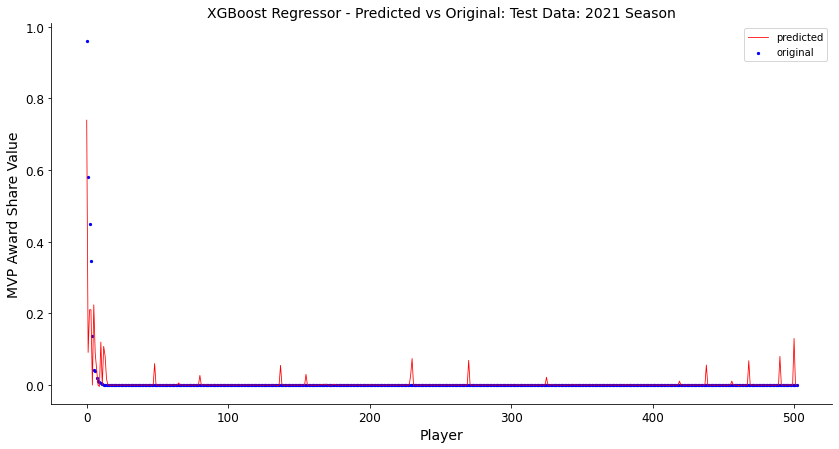

In [21]:
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, pred_xgb, lw=0.8, color="red", label="predicted")
plt.legend()
plt.title("XGBoost Regressor - Predicted vs Original: Test Data: 2021 Season")
plt.xlabel("Player")
plt.ylabel("MVP Award Share Value")
plt.show()

### Validate ML Model on Validation Data <a name='val'></a>

#### XGBoost Regressor <a name='lgbm_val'></a>

In [22]:
# XGBoost Regressor Predict the model on Validation Data
pred_xgb = xgb_model.predict(X_val).round(3)
 
# R2, MSE, RMSE scoring
mse = mean_squared_error(y_val, pred_xgb)
r2 = round(r2_score(y_val, pred_xgb),3)

print("Validation prediction R2: %.4f" %r2)
print("Validation prediction MSE: %.4f" % mse)
print("Validation prediction RMSE: %.4f" % (mse**(1/2.0)))

Validation prediction R2: 0.8900
Validation prediction MSE: 0.0004
Validation prediction RMSE: 0.0189


In [23]:
df_val['mvp_award_share_PRED'] = pred_xgb
df_val['was_mpv_rank_PRED'] = df_val.groupby('season')['mvp_award_share_PRED'].rank(method='max',ascending=False)
df_val['was_mpv_rank_PRED'] = df_val['was_mpv_rank_PRED'].astype(int)
pred_output = df_val[['season','player','pos','team_id','was_mvp_TF','award_share','was_mpv_rank','mvp_award_share_PRED','was_mpv_rank_PRED']]
pred_output['was_mpv_rank'] = pred_output['was_mpv_rank'].astype(int)
pred_output.sort_values(by=['mvp_award_share_PRED'], ascending=False).head(10)

,season,player,pos,team_id,was_mvp_TF,award_share,was_mpv_rank,mvp_award_share_PRED,was_mpv_rank_PRED
14263,2022,Nikola Jokić,C,DEN,True,0.875,1,0.898,1
14264,2022,Joel Embiid,C,PHI,False,0.706,2,0.589,2
14265,2022,Giannis Antetokounmpo,PF,MIL,False,0.595,3,0.569,3
14267,2022,Luka Dončić,PG,DAL,False,0.146,5,0.394,4
14274,2022,LeBron James,PF,LAL,False,0.001,12,0.191,5
14273,2022,Kevin Durant,PF,BRK,False,0.001,12,0.143,6
14780,2022,Trae Young,PG,ATL,False,0.000,520,0.137,7
14268,2022,Jayson Tatum,SF,BOS,False,0.043,6,0.105,8
14266,2022,Devin Booker,SG,PHO,False,0.216,4,0.085,9
14269,2022,Ja Morant,PG,MEM,False,0.010,7,0.066,10


Backing off send_request(...) for 2.9s (requests.exceptions.SSLError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)'))))


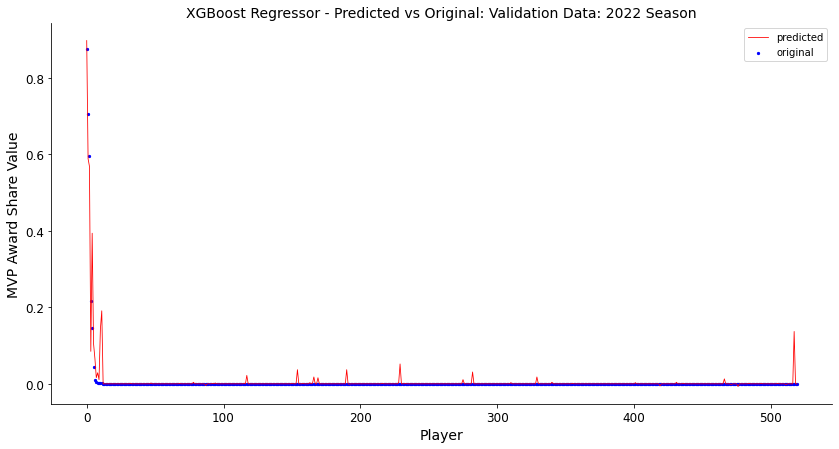

In [24]:
x_ax = range(len(y_val))
plt.scatter(x_ax, y_val, s=5, color="blue", label="original")
plt.plot(x_ax, pred_xgb, lw=0.8, color="red", label="predicted")
plt.legend()
plt.title("XGBoost Regressor - Predicted vs Original: Validation Data: 2022 Season")
plt.xlabel("Player")
plt.ylabel("MVP Award Share Value")
plt.show()

### Model Development and Fit Findings

<div class="alert alert-block alert-warning"> For the 2021 season Extra Tress and Random Foreast performed very close. While XGBoost outperformed both. In the 2022 season Extra Trees and XGBoost has results that were close but in the end XGBoost out performed Extra Trees. The optimal HyperParameters for each model was as such:

- XGBoost best hyperparameters: {'subsample': 0.5, 'objective': 'reg:squarederror', 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}

<a name='conclu'></a>

## Conclusion Statements <a name='con'></a>

#### <div class="alert alert-block alert-success">In reviewing our objectives with model performance in Test and Validation, as well as implementing a Voting Regressor with the 3 top performing models, the model that performed the best was the XGBoost Regressor. With this said the final model we would implement would be XGBoost Regressor with the following hyperparameters: {'subsample': 0.7, 'objective': 'reg:squarederror', 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}

#### Learning Curve Plot<a name='lc'></a>

In [28]:
train_sizes, train_scores, test_scores = learning_curve(xgb_model, X=X_train, y=y_train,
                                                       cv=5, train_sizes=np.linspace(0.01, 1.0, 10),
                                                     n_jobs=-1,scoring = 'neg_root_mean_squared_error',random_state=42)

Backing off send_request(...) for 28.5s (requests.exceptions.SSLError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)'))))


In [29]:
# Calculate training and test mean and std
 
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

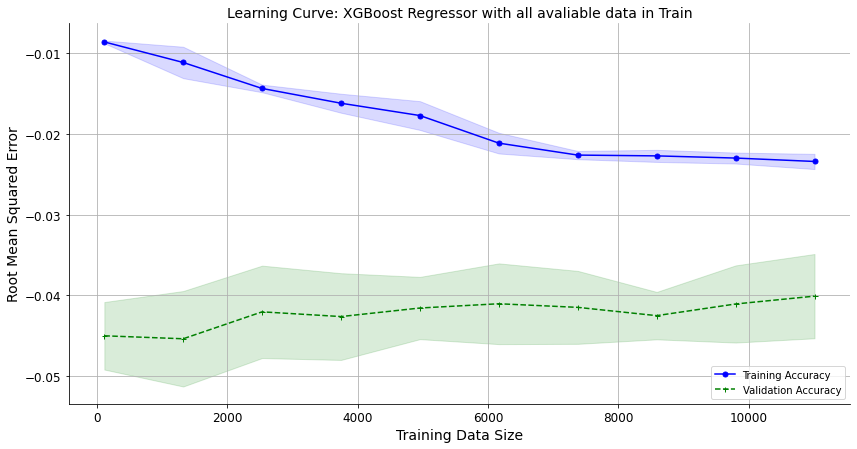

Backing off send_request(...) for 121.6s (requests.exceptions.SSLError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)'))))


In [30]:
# Plot the learning curve
 
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve: XGBoost Regressor with all avaliable data in Train')
plt.xlabel('Training Data Size')
plt.ylabel('Root Mean Squared Error')
plt.grid()
plt.legend(loc='lower right')
plt.show()